# Data Cleaning and Overview


# Step 1: Import Python packages and define functions
I need to import (pandas and numpy) packages for cleaning the dataset.<br> 
Since the control data values file (aux_dataset.xlsx file) is provided, I will define some functions to convert the excel worksheets into dictionaries. Then, I use the dictionaries to replace the values accordingly to the control values for each column of the dataset.<br>
To ensure the uniformity of the data, I replaced "FALSE" to "False", "NULL_" to "NULL" and "rectal" to "Rectal" in "clean" column of "braf_mutation" worksheet inside aux_dataset.xlsx file

In [1250]:
#import packages
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

In [1251]:
# Define functions 
file = './aux_dataset.xlsx'

# Function to get dictionaries from aux_dataset.xlsx file for cleaning
def get_dict(file,i):
    df_i=pd.read_excel('./aux_dataset.xlsx', sheet_name=i,header=0,index_col=None)
    # replaced "" to "NULL", "FALSE" to "False", "NULL_" to "NULL"
    df_i.clean=df_i.clean.astype(object).replace(np.nan, 'NULL').replace('FALSE','False').replace('NULL_','NULL')
    dict_i=df_i.set_index('raw')['clean'].to_dict()
    return dict_i

# Replace value according to dictionaries
def replace_all(df,col, dic):
    for i, j in dic.items():
        df[str(col)] = df[str(col)].replace(i, j)
    return df[str(col)].astype(str)

def missing_data(df):
    no_null = df.notnull().sum()
    missing = df.isnull().sum()
    percent = df.isnull().sum()/df.shape[0]*100
    missing_data = pd.concat([no_null,missing, percent], axis=1, 
                             keys=['NOT-null','Missing', 'Percent Missing'])
    return missing_data.sort_values(by='Missing', ascending=False)


# Step 2: Import, explore and clean the dataset


In [1252]:
cota_data = pd.read_csv('./cota_ds_analyst_dataset.csv')

print('The dataset has {} rows and {} columns'.format(cota_data.shape[0],cota_data.shape[1]))

The dataset has 10000 rows and 10 columns


In [1253]:
cota_data.head()

,patient_id,date_of_birth,stage,rectal_or_colon_ca,braf_mutation,resection,lymph_nodes_removed,therapy_type,patient_preference,histological_grade
0,patient_id_0,"December 28, 1953",iiia,colon,not assessed,r0: no residual tumor,1 positive,metastatic,not assessed,g2
1,patient_id_1,2009-07-09,stage iiia,colon,not assessed,not assessed,14,metastatic,no,3
2,patient_id_2,1983-04-16,iiic,colon,not assessed,not assessed,24,metastatic,not assessed,g1
3,patient_id_3,2018-08-13,i,rectal,not assessed,not assessed,1 positive,metastatic,no,not reported
4,patient_id_4,"October 09, 2017",iib,rectal,not assessed,not assessed,>12,adjuvant,yes,g1


In [1254]:
missing_data(cota_data)

,NOT-null,Missing,Percent Missing
resection,9211,789,7.89
lymph_nodes_removed,9620,380,3.80
rectal_or_colon_ca,9732,268,2.68
histological_grade,9885,115,1.15
braf_mutation,9974,26,0.26
patient_id,10000,0,0.00
date_of_birth,10000,0,0.00
stage,10000,0,0.00
therapy_type,10000,0,0.00
patient_preference,10000,0,0.00


We can see that the values in each columns are not uniform, so we will need to:
1. "date_of_birth": reformat date
2. "stage": remove the word stage and reformat values
3. "rectal_or_colon_ca": replace the values according to control values<br>
   "braf_mutation": replace the values according to control values<br>
   "therapy_type": replace the values according to control values<br>
4. "resection": replace values with either r0, r1, r2 or NULL
5. "lymph_nodes_removed": reformat values to integers or NULL
6. "patient_preference": reformat values to boolean
7. "histological_grade": replace values with g1, g2, g3, g4 or NULL

### 1. date_of_birth column

The format of date are not uniform

In [1321]:
#cota_data.columns

In [1256]:
print('Unique values \n',cota_data.date_of_birth.unique())

Unique values 
 ['December 28, 1953' '2009-07-09' '1983-04-16' ... '1953-04-18'
 '2012-07-15' 'September 24, 1974']


In [1257]:
cota_data.date_of_birth=pd.to_datetime(cota_data.date_of_birth, errors='ignore')

In [1258]:
cota_data.date_of_birth.head()

0   1953-12-28
1   2009-07-09
2   1983-04-16
3   2018-08-13
4   2017-10-09
Name: date_of_birth, dtype: datetime64[ns]

### 2. stage column

In [1259]:
cota_data.stage.unique()

array(['iiia', 'stage iiia', 'iiic', 'i', 'iib', 'iiib', 'not assessed',
       'stage iib', 'stage iiib', 'ivb', 'iia', 'stage i', 'stage iva',
       'stage iia', 'iva', 'not staged', 'stage ivb', 'stage 0', 'iic',
       'stage iiic', 'unknown', 'stage i (staging not completed)',
       'not reported', 'no neoplasm', 'stage 1', '0', '!!a',
       'orif of pathologic fracture arm by ortho', 'no records', '111a',
       '1', 'not fully staged', 'stageiva', 'not reporte', 'stage iic'],
      dtype=object)

In [1260]:
dict_stage={'not assessed':'Not Assessed','not staged':'Not Staged', 'unknown':'NULL',
            'i (staging not completed)':'i', 'not reported':'Not Reported', '1':'i',
            '!!a':'iia', 'orif of pathologic fracture arm by ortho':'NULL', 
            'no records':'NULL','111a':'iiia', 'not fully staged':'NULL',
            'not reporte':'Not Reported'}

In [1261]:
cota_data.stage=cota_data.stage.str.lstrip('stage ').str.rstrip('abc')

In [1262]:
cota_data.stage=replace_all(cota_data,'stage',dict_stage)

In [1263]:
cota_data.stage.value_counts()

iv              3197
iii             2322
ii              1640
Not Assessed    1576
i                898
0                141
Not Staged        63
Not Reported      57
NULL              54
no neoplasm       20
111               17
!!                15
Name: stage, dtype: int64

Stage values 
 iv              3197
iii             2322
ii              1640
Not Assessed    1576
i                898
0                141
Not Staged        63
Not Reported      57
NULL              54
no neoplasm       20
111               17
!!                15
Name: stage, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


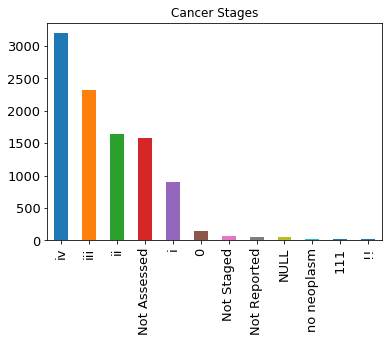

In [1323]:
print('Stage values \n',cota_data.stage.value_counts())
print(cota_data.stage.value_counts().plot(kind='bar',fontsize=13,title='Cancer Stages'))

### 3. rectal_or_colon_ca, braf_mutation, therapy_type columns

In [1265]:
xls = pd.ExcelFile('./aux_dataset.xlsx', on_demand = True)
for i in xls.sheet_names:
    dict_i=get_dict(file,str(i))
    cota_data[str(i)]= replace_all(cota_data,str(i), dict_i)
    

In [1266]:
cota_data.rectal_or_colon_ca.unique()

array(['Colon', 'Rectal', 'NULL'], dtype=object)

In [1267]:
cota_data.braf_mutation.unique()

array(['Not Assessed', 'False', 'Not Reported', 'True', 'NULL'],
      dtype=object)

In [1268]:
cota_data.therapy_type.unique()

array(['metastatic', 'adjuvant', 'neoadjuvant'], dtype=object)

Colon     7497
Rectal    2118
NULL       385
Name: rectal_or_colon_ca, dtype: int64


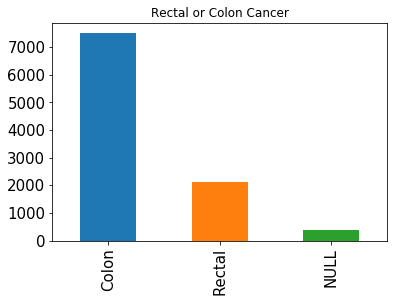

In [1269]:
print(cota_data.rectal_or_colon_ca.value_counts())
print(cota_data.rectal_or_colon_ca.value_counts().plot(kind='bar',fontsize=15,title='Rectal or Colon Cancer'))

Not Assessed    8371
False           1152
Not Reported     266
True             175
NULL              36
Name: braf_mutation, dtype: int64


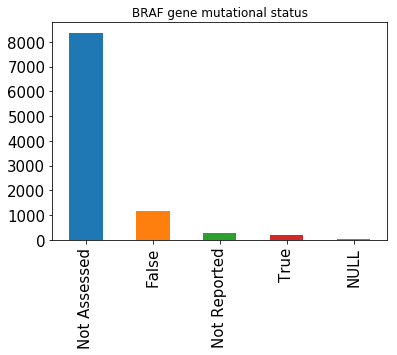

In [1270]:
print(cota_data.braf_mutation.value_counts())
cota_data.braf_mutation.value_counts().plot(kind='bar',fontsize=15,title='BRAF gene mutational status')

metastatic     3935
adjuvant       3271
neoadjuvant    2794
Name: therapy_type, dtype: int64


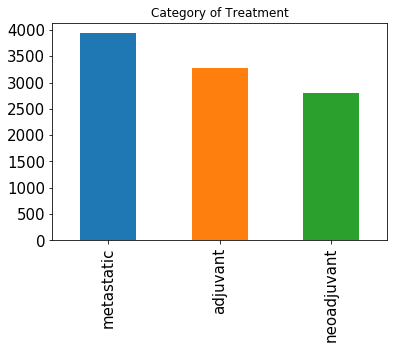

In [1271]:
print(cota_data.therapy_type.value_counts())
cota_data.therapy_type.value_counts().plot(kind='bar',title='Category of Treatment',fontsize=15)

### 4. resection column

In [1272]:
cota_data.resection.unique()

array(['r0: no residual tumor', 'not assessed', 'not reported', 'r0',
       'r1: microscopic residual tumor', nan, 'r1',
       'r2: macroscopic residual tumor', 'r2: macrospopic residual tumor',
       'r2', 'r2 (colonoscopy only)', 'r2, then 2nd time r0'],
      dtype=object)

In [1273]:
dict_resection={'r0: no residual tumor':'r0', 'not assessed':'Not Assessed',
                'not reported':'Not Reported','r1: microscopic residual tumor':'r1',
                np.nan:'NULL','r2: macroscopic residual tumor':'r2',
                'r2: macrospopic residual tumor':'r2','r2 (colonoscopy only)':'r2',
                'r2, then 2nd time r0':'r0'}

In [1274]:
#cota_data.resection=cota_data.resection.astype(str).str[0:2]
cota_data.resection=replace_all(cota_data,'resection',dict_resection)

In [1275]:
cota_data.resection.unique()

array(['r0', 'Not Assessed', 'Not Reported', 'r1', 'NULL', 'r2'],
      dtype=object)

Not Assessed    4673
r0              2703
Not Reported    1496
NULL             789
r1               251
r2                88
Name: resection, dtype: int64


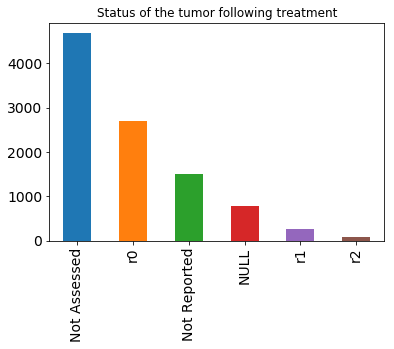

In [1276]:
print(cota_data.resection.value_counts())
cota_data.resection.value_counts().plot(kind='bar',fontsize=14,title='Status of the tumor following treatment')

### 5. lymph_nodes_removed column

In [1277]:
cota_data.lymph_nodes_removed.unique()

array(['1 positive', '14', '24', '>12', '15', '21', '25', '9', '0', nan,
       '>18', '> 12', '12 (post tx)', '26', '5', '18', '11', '22', 'no',
       '12', '30', '13', '20', '<12', '16', '33', '17', '0 reported',
       '>7', '10', 'notassessed', '19', '7', '32', 'thirty', '41', '52',
       '43', '28', '46', '27', '36', '6', '23', 'not assesssed', '29',
       '47', 'not assessed from rectal', '51', 'not assesesd', '56',
       'no records', '69', '34', 'not assesses', '8', '3',
       'not available', 'not asssessed'], dtype=object)

In [1278]:
#cota_data.lymph_nodes_removed.value_counts()

In [1279]:
dict_lymph_nodes_removed={'1 positive':'1','0 reported':'0','no':'NO',
                          'notassessed':'Not Assessed',
                          'thirty':'30',np.nan:'NULL','not assesssed':'Not Assessed',
                          'not assessed from rectal':'Not Assessed',
                          'not assesesd':'Not Assessed','12 (post tx)':'12',
                          'no records':'NULL','not assesses':'Not Assessed',
                          'not available':'NULL','not asssessed':'Not Assessed'}

In [1280]:
cota_data.lymph_nodes_removed=replace_all(cota_data,'lymph_nodes_removed',dict_lymph_nodes_removed)
cota_data.lymph_nodes_removed=cota_data.lymph_nodes_removed.str.lstrip('>').str.lstrip('<').str.lstrip('> ')


In [1281]:
cota_data.lymph_nodes_removed.unique()

array(['1', '14', '24', '12', '15', '21', '25', '9', '0', 'NULL', '18',
       '26', '5', '11', '22', 'NO', '30', '13', '20', '16', '33', '17',
       '7', '10', 'Not Assessed', '19', '32', '41', '52', '43', '28',
       '46', '27', '36', '6', '23', '29', '47', '51', '56', '69', '34',
       '8', '3'], dtype=object)

12    2134
18    1006
0      826
1      509
7      426
Name: lymph_nodes_removed, dtype: int64


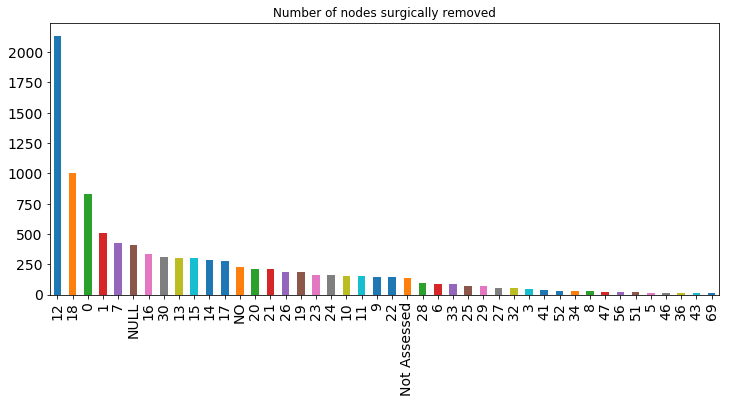

In [1282]:
print(cota_data.lymph_nodes_removed.value_counts().head())
cota_data.lymph_nodes_removed.value_counts().plot(kind='bar',figsize=(12,5),fontsize=14,title='Number of nodes surgically removed')

### 6. patient_preference column

In [1283]:
cota_data.patient_preference.unique()

array(['not assessed', 'no', 'yes', 'n o', 'yes (not at jtcc)',
       'no records', '0', 'yes (no consult)', 'yes(lost to follow up)',
       'consult only', 'unknown'], dtype=object)

In [1284]:
dict_patient_preference={'not assessed':'Not Assessed', 'no':'False', 'yes':'True', 
                         'n o':'False','yes (not at jtcc)':'True','no records':'NULL',
                         '0':'False','yes (no consult)':'True', 
                         'yes(lost to follow up)':'True','consult only':'True', 
                         'unknown':'NULL'}

In [1285]:
cota_data.patient_preference=replace_all(cota_data,'patient_preference',dict_patient_preference)

In [1286]:
cota_data.patient_preference.unique()

array(['Not Assessed', 'False', 'True', 'NULL'], dtype=object)

False           6701
Not Assessed    1799
True            1475
NULL              25
Name: patient_preference, dtype: int64


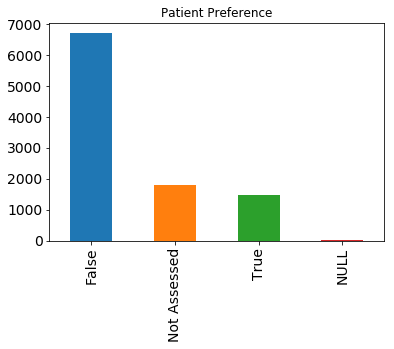

In [1304]:
print(cota_data.patient_preference.value_counts().head())
cota_data.patient_preference.value_counts().plot(kind='bar',fontsize=14,title='Patient Preference')


### 7. histological_grade column

In [1314]:
#cota_data.histological_grade.unique()

In [1288]:
dict_histological_grade={'3':'g3','not reported':'Not Reported', 
                         'not assessed':'Not Assessed','2':'g2','1':'g1', np.nan:'NULL',
                         'gi':'g1', 'low grade':'g1', 'mucinous carcinoma':'NULL',
                         'no records':'NULL', 'ivb':'NULL', 'high grade(3)':'g3', '4':'g4'}

In [1289]:
cota_data.histological_grade=replace_all(cota_data,'histological_grade',dict_histological_grade)

g2              4646
Not Assessed    2327
g3              1917
g1               696
Not Reported     203
NULL             173
g2-3              15
no neoplasm       13
g4                10
Name: histological_grade, dtype: int64


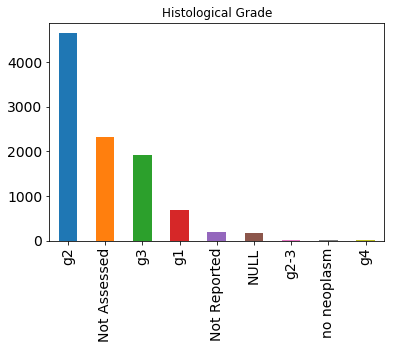

In [1309]:
print(cota_data.histological_grade.value_counts())
cota_data.histological_grade.value_counts().plot(kind='bar',fontsize=14,title='Histological Grade')


In [1320]:
dict_histological_grade.apply(pd.Series)

AttributeError: 'dict' object has no attribute 'apply'

In [1306]:
# Save the cleaned dataset
cota_data.to_csv('cota_ds_analyst_dataset_Cao_Lexi.csv',index=False,index_label=None)


In [1313]:
cota_data[cota_data!='NULL'].sum()

patient_id      patient_id_0patient_id_1patient_id_2patient_id...
therapy_type    metastaticmetastaticmetastaticmetastaticadjuva...
dtype: object

# Step 3: Answers to given questions

### 1. How many patients have a therapy type of ‘metastatic’ and stage IV (includes IVa,b,c etc..)?
Answer: 1246 patients

In [1291]:
metastatic_stageiv=cota_data[(cota_data.therapy_type=='metastatic')& (cota_data.stage=='iv')]
print('1. There are {} patients have a therapy type of metastatic and stage IV'.format(metastatic_stageiv.shape[0]))

1. There are 1259 patients have a therapy type of metastatic and stage IV


### 2.	How many patients have colon cancer, with stage III (include IIIa,b,c.. etc) and therapy type of ‘adjuvant’?
Answer: 580 patients

In [1292]:
colon_stageiii_adjuvant=cota_data[(cota_data.rectal_or_colon_ca=='Colon')&(cota_data.stage=='iii')&(cota_data.therapy_type=='adjuvant')]
print('2. There are {} patients have colon cancer, with stage III and therapy type of adjuvant'.format(colon_stageiii_adjuvant.shape[0]))


2. There are 574 patients have colon cancer, with stage III and therapy type of adjuvant


### 3.	What proportion of patients have rectal cancer?

In [1293]:
rectal=cota_data[(cota_data.rectal_or_colon_ca=='Rectal')]
rectal_and_colon=cota_data[(cota_data.rectal_or_colon_ca=='Rectal')]
print('3. Proportion of patients have rectal cancer is {}'.format(rectal.shape[0]/cota_data.shape[0]))

3. Proportion of patients have rectal cancer is 0.2118


### 4.	What is the probability mass function of lymph_nodes_removed?

 A Probability Mass Function (PMF), also called a frequency function, gives probabilities for discrete random variables. 
 
A PMF equation looks like this: P(X = x), which means the probability that X takes on some value x.

I will drop NULL, Not Assessed and NO values because they are not helpful for the calculation, and because values with NO are ambiguous to be included in this calculation

In [1300]:
# Drop NULL and Not Assessed values because they're not helpful for calculation
lymph_nodes_removed=cota_data.lymph_nodes_removed[(cota_data.lymph_nodes_removed!='NULL')&(cota_data.lymph_nodes_removed!='Not Assessed')&(cota_data.lymph_nodes_removed!='NO')]
print('After dropping NULL, Not Assessed and NO values, lymph_nodes_removed column has {} rows'.format(lymph_nodes_removed.shape[0]))


After dropping NULL, Not Assessed and NO values, lymph_nodes_removed column has 9224 rows


In [1301]:
# Probability mass function is equal to total counts of each value in lymph_nodes_removed
# divided by total number of entries in lymph_nodes_removed column (excluding NULL and 
# Not Assessed values)
pmf = lymph_nodes_removed.value_counts()/ len(lymph_nodes_removed)
pmf

12    0.231353
18    0.109063
0     0.089549
1     0.055182
7     0.046184
16    0.036210
30    0.033933
13    0.032958
15    0.032415
14    0.030681
17    0.029814
20    0.022984
21    0.022767
26    0.020490
19    0.019948
23    0.017780
24    0.017563
10    0.017021
11    0.016262
9     0.015720
22    0.015720
28    0.010516
6     0.009866
33    0.009540
29    0.007372
25    0.007372
27    0.005421
32    0.005421
3     0.004553
41    0.003903
52    0.003036
34    0.002927
8     0.002819
47    0.002060
56    0.002060
51    0.001843
5     0.001735
46    0.001735
43    0.001518
36    0.001518
69    0.001193
Name: lymph_nodes_removed, dtype: float64

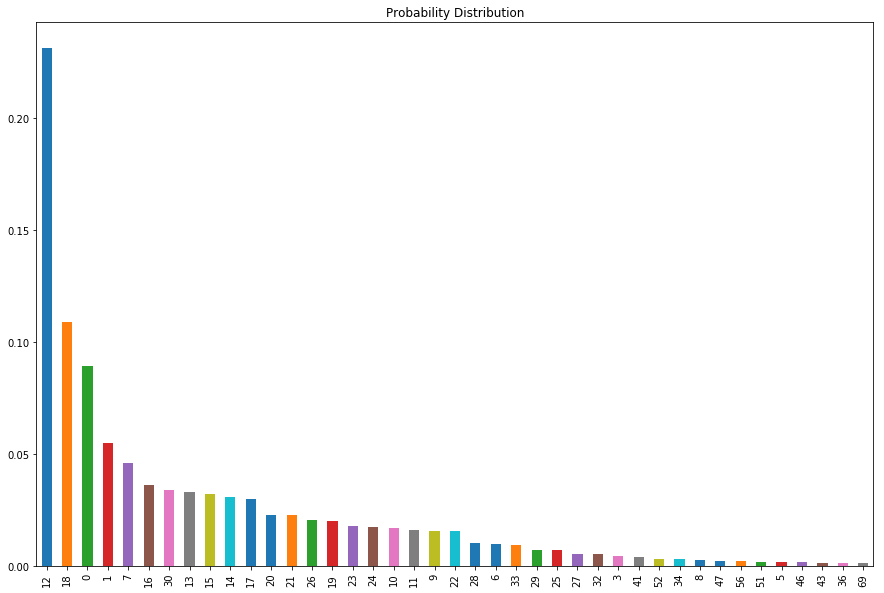

In [1302]:
pmf.plot(kind='bar',figsize=(15,10),title='Probability Distribution')